# IF3070 Foundations of Artificial Intelligence | Tugas Besar 2


Group Number: 03

Group Members:
- Muhammad Yaafi Wasesa Putra (18222052)
- Taufiq Ramadhan Ahmad (18222060)
- Josia Ryan Juliandy Silalahi (18222075)
- Muhammad Adli Arindra (18222089)

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.discriminant_analysis import StandardScaler

from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats.mstats import winsorize
from difflib import SequenceMatcher

## Import Dataset

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?id=16zqtESqP-X6Maenwn4zAX5nXAeLsjTQp')
df.head()


,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,1,NaN,https://www.northcm.ac.th,24.0,www.northcm.ac.th,17.0,0.0,NaN,0.800000,NaN,...,0.0,0.0,1.0,NaN,3.0,NaN,69.0,NaN,NaN,1
1,4,8135291.txt,http://uqr.to/1il1z,NaN,NaN,NaN,NaN,to,1.000000,0.000896,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0
2,5,586561.txt,https://www.woolworthsrewards.com.au,35.0,www.woolworthsrewards.com.au,28.0,0.0,au,0.857143,NaN,...,1.0,0.0,1.0,33.0,7.0,8.0,15.0,NaN,2.0,1
3,6,NaN,NaN,31.0,NaN,NaN,NaN,com,0.562500,0.522907,...,1.0,0.0,1.0,24.0,5.0,14.0,NaN,NaN,NaN,1
4,11,412632.txt,NaN,NaN,www.nyprowrestling.com,22.0,0.0,NaN,1.000000,NaN,...,0.0,0.0,1.0,NaN,NaN,14.0,NaN,0.0,NaN,1


# 1. Split Training Set and Validation Set

This code splits a dataset `df` into a training set `train_set` and a validation set `val_set` using an 80-20 split. The stratify parameter ensures that the distribution of the label column in the original dataset is maintained in both subsets. The random_state parameter is set to 43 to make the split reproducible, ensuring consistent results across runs



In [ ]:
train_set, val_set = train_test_split(
    df, test_size = 0.2,
    random_state = 43,
    stratify = df['label'])

# 2. Data Cleaning and Preprocessing

Data cleaning and preprocessing are crucial because they directly impact the quality of insights and the performance of machine learning models. Here’s why they are useful:


*   **Improved Data Quality**: Cleaning removes errors, inconsistencies, and irrelevant data, ensuring that the dataset accurately represents the problem. Without this step, noisy or inaccurate data can lead to flawed analysis, biased results, or unreliable predictions.
*   **Better Model Performance**: Preprocessing transforms raw data into a structured, standardized format that models can understand and effectively use. For example, scaling and normalizing data can enhance the performance of algorithms sensitive to feature magnitude, while encoding ensures compatibility with machine learning pipelines. Proper preprocessing helps prevent issues like overfitting and underfitting, leading to better generalization on unseen data.

By ensuring data integrity and optimizing its format, these steps save time, reduce errors, and enable more robust, interpretable, and actionable outcomes.

## A. Data Cleaning

### I. Handling Missing Data

It's important to handle missing data correctly since it can make or break the model that we're making. Here are the methods we used:
* Impute a feature from another feature
* Impute a feature using it's median
* Removing the row where the `URL` is `NaN`

In [ ]:
def imputeDomain(row):
    if pd.notna(row["Domain"]):
        return row["Domain"]
    if pd.isna(row["URL"]):
        return np.nan
    return row["URL"].split("://")[1].split("/")[0]

def imputeURLLength(row):
    if pd.notna(row["URLLength"]):
        return row["URLLength"]
    if pd.isna(row["URL"]):
        if pd.notna(row["DomainLength"]):
            return row["DomainLength"] + 8
        return np.nan
    return len(row["URL"])

def imputeDomainLength(row):
    if pd.notna(row["DomainLength"]):
        return row["DomainLength"]
    if pd.isna(row["Domain"]):
        return np.nan
    return len(row["Domain"])

def imputeIsDomainIP(row):
    def contains_letter(string):
        return any(char.isalpha() for char in string)

    if pd.notna(row["IsDomainIP"]):
        return row["IsDomainIP"]

    if pd.notna(row["Domain"]) and not contains_letter(row["Domain"]):
        return 1

    return 0

def imputeTLD(row):
    if pd.notna(row["TLD"]):
        return row["TLD"]
    if pd.notna(row["Domain"]):
        return row["Domain"].split('.')[-1]
    return np.nan

def imputeCharContinuationRate(row, mean=None):
    if pd.notna(row["CharContinuationRate"]):
        return row["CharContinuationRate"]
    return mean if mean is not None else 0

def imputeTLDLegitimateProb(row, mode_dict):
    if pd.notna(row["TLD"]):
        return mode_dict.get(row["TLD"], np.nan)
    return row["TLDLegitimateProb"]

def imputeURLCharProb(row, mean=None):
    if pd.notna(row["URLCharProb"]):
        return row["URLCharProb"]
    return mean if mean is not None else 0

def imputeTLDLength(row):
    if pd.notna(row["TLDLength"]):
        return row["TLDLength"]
    if pd.isna(row["TLD"]):
        return np.nan
    return len(row["TLD"])

def imputeNoOfSubDomain(row):
    if pd.notna(row["NoOfSubDomain"]):
        return row["NoOfSubDomain"]
    if pd.notna(row["Domain"]):
        return len(row["Domain"].split('.')) - 1
    return np.nan

def imputeNoOfObfuscatedChar(row):
    if row["HasObfuscation"] == 0:
        return 0
    if pd.notna(row["NoOfObfuscatedChar"]):
        return row["NoOfObfuscatedChar"]
    if pd.notna(row["URL"]):
        return row["URL"].count('%') * 3
    return np.nan

def imputeObfuscationRatio(row):
    if pd.notna(row["ObfuscationRatio"]):
        return row["ObfuscationRatio"]
    if pd.isna(row["NoOfObfuscatedChar"]) or pd.isna(row["URLLength"]) or row["URLLength"] == 0:
        return np.nan
    return row["NoOfObfuscatedChar"] / row["URLLength"]

def imputeNoOfLettersInURL(row):
    if pd.notna(row["NoOfLettersInURL"]):
        return row["NoOfLettersInURL"]
    if pd.isna(row["URL"]):
        return np.nan
    return sum(char.isalpha() for char in row["URL"])

def imputeLetterRatioInURL(row):
    if pd.notna(row["LetterRatioInURL"]):
        return row["LetterRatioInURL"]
    if pd.isna(row["NoOfLettersInURL"]) or pd.isna(row["URLLength"]) or row["URLLength"] == 0:
        return np.nan
    return row["NoOfLettersInURL"] / row["URLLength"]

def imputeNoOfDegitsInURL(row):
    if pd.notna(row["NoOfDegitsInURL"]):
        return row["NoOfDegitsInURL"]
    if pd.isna(row["URL"]):
        return np.nan
    return sum(char.isdigit() for char in row["URL"])

def imputeDegitRatioInURL(row):
    if pd.notna(row["DegitRatioInURL"]):
        return row["DegitRatioInURL"]
    if pd.isna(row["NoOfDegitsInURL"]) or pd.isna(row["URLLength"]) or row["URLLength"] == 0:
        return np.nan
    return row["NoOfDegitsInURL"] / row["URLLength"]

def imputeNoOfEqualsInURL(row):
    if pd.notna(row["NoOfEqualsInURL"]):
        return row["NoOfEqualsInURL"]
    if pd.isna(row["URL"]):
        return 0
    return row["URL"].count('=')

def imputeNoOfQMarkInURL(row):
    if pd.notna(row["NoOfQMarkInURL"]):
        return row["NoOfQMarkInURL"]
    if pd.isna(row["URL"]):
        return 0
    return row["URL"].count('?')

def imputeNoOfAmpersandInURL(row):
    if pd.notna(row["NoOfAmpersandInURL"]):
        return row["NoOfAmpersandInURL"]
    if pd.isna(row["URL"]):
        return 0
    return row["URL"].count('&')

def imputeNoOfOtherSpecialCharsInURL(row):
    if pd.notna(row["NoOfOtherSpecialCharsInURL"]):
        return row["NoOfOtherSpecialCharsInURL"]
    if pd.isna(row["URL"]):
        return 0
    return sum(1 for char in row["URL"] if not char.isalnum() and char not in ['=', '?', '&', '/', '.'])

def imputeSpacialCharRatioInURL(row):
    if pd.notna(row["SpacialCharRatioInURL"]):
        return row["SpacialCharRatioInURL"]
    if pd.isna(row["URLLength"]) or row["URLLength"] == 0:
        return 0
    special_chars = (
        row.get("NoOfOtherSpecialCharsInURL", 0) +
        row.get("NoOfEqualsInURL", 0) +
        row.get("NoOfQMarkInURL", 0) +
        row.get("NoOfAmpersandInURL", 0)
    )
    return special_chars / row["URLLength"]

def imputeIsHTTPS(row):
    if pd.notna(row["IsHTTPS"]):
        return row["IsHTTPS"]
    if pd.notna(row["URL"]):
        return 1 if row["URL"].startswith("https") else 0
    return np.nan

def imputeDomainTitleMatchScore(row):
    if pd.notna(row["DomainTitleMatchScore"]):
        return row["DomainTitleMatchScore"]
    if pd.notna(row["URLTitleMatchScore"]):
        return row["URLTitleMatchScore"]

    domain = str(row.get("Domain", "")) if pd.notna(row.get("Domain", "")) else ""
    title = str(row.get("Title", "")) if pd.notna(row.get("Title", "")) else ""
    tld_length = int(row.get("TLDLength", 0)) if pd.notna(row.get("TLDLength", 0)) else 0

    if not domain or not title:
        return 0

    domain_without_tld = domain[:-tld_length-1] if len(domain) > tld_length else domain

    match_ratio = SequenceMatcher(None, domain_without_tld, title).ratio()

    return match_ratio * 100

def imputeFilename(row, default_filename="unknown_file.txt"):
    if pd.notna(row["FILENAME"]):
        return row["FILENAME"]
    if pd.notna(row["URL"]):
        return row["URL"].split("/")[-1]
    return default_filename

def imputeDomainFromFilename(row):
    if pd.notna(row["Domain"]):
        return row["Domain"]
    if pd.notna(row["FILENAME"]):
        return row["FILENAME"].split(".")[0]
    return np.nan

def imputeURLLengthGroup(row, mean_lengths):
    if pd.notna(row["URLLength"]):
        return row["URLLength"]
    group = row.get("TLD", "unknown")
    return mean_lengths.get(group, np.nan)

def imputeIsDomainIPFromPatterns(row):
    if pd.notna(row["IsDomainIP"]):
        return row["IsDomainIP"]
    if pd.notna(row["Domain"]):
        return 1 if all(part.isdigit() for part in row["Domain"].split(".")) else 0
    return np.nan

def imputeHasObfuscationByHeuristics(row):
    if pd.notna(row["HasObfuscation"]):
        return row["HasObfuscation"]
    if pd.notna(row["URL"]):
        return 1 if "%" in row["URL"] else 0
    return np.nan

def imputeLabelFromPatterns(row):
    if pd.notna(row.get("label")):
        return row["label"].split(";")[0]
    return "unknown"

def imputeNoOfRedirects(row):
    if pd.notna(row["NoOfURLRedirect"]):
        return row["NoOfURLRedirect"]
    if pd.notna(row["NoOfSelfRedirect"]):
        return row["NoOfSelfRedirect"]
    return 0

def imputeHasSocialFeatures(row):
    if pd.notna(row["HasSocialNet"]):
        return row["HasSocialNet"]
    if pd.notna(row["URL"]):
        social_keywords = ["facebook", "twitter", "linkedin", "instagram"]
        return 1 if any(keyword in row["URL"] for keyword in social_keywords) else 0
    return 0

def imputeLineOfCode(row, fill_value=100):
    if pd.notna(row["LineOfCode"]):
        return row["LineOfCode"]
    return fill_value

def imputeLargestLineLength(row, fill_value=200):
    if pd.notna(row["LargestLineLength"]):
        return row["LargestLineLength"]
    return fill_value

def imputeHasFavicon(row):
    if pd.notna(row["HasFavicon"]):
        return row["HasFavicon"]
    return 0

def imputeRobots(row):
    if pd.notna(row["Robots"]):
        return row["Robots"]
    return 0

def imputeIsResponsive(row):
    if pd.notna(row["IsResponsive"]):
        return row["IsResponsive"]
    return 0

def imputeHasDescription(row):
    if pd.notna(row["HasDescription"]):
        return row["HasDescription"]
    return 0

def imputeNoOfPopup(row):
    if pd.notna(row["NoOfPopup"]):
        return row["NoOfPopup"]
    return 0

def imputeNoOfiFrame(row):
    if pd.notna(row["NoOfiFrame"]):
        return row["NoOfiFrame"]
    return 0

def imputeHasTitle(row):
    if pd.notna(row["HasTitle"]):
        return row["HasTitle"]
    if pd.notna(row["Title"]):
        return 1
    return np.nan

from scipy.stats import entropy

def calculate_entropy(url):
    if pd.notna(url):
        char_counts = pd.value_counts(list(url), normalize=True)
        return entropy(char_counts)
    return np.nan

def count_punctuation(url):
    if pd.notna(url):
        punctuation_count = sum(1 for char in url if char in ['.', '/', '-'])
        return punctuation_count
    return np.nan

def domain_to_url_ratio(row):
    if pd.notna(row["DomainLength"]) and pd.notna(row["URLLength"]):
        return row["DomainLength"] / row["URLLength"]
    return np.nan

def numeric_char_ratio(domain):
    if pd.notna(domain):
        numeric_count = sum(1 for char in domain if char.isdigit())
        return numeric_count / len(domain)
    return np.nan

def word_count(url):
    if pd.notna(url):
        return len(url.split('/')) - 1
    return np.nan

sensitive_keywords = ["login", "secure", "bank"]
def contains_sensitive_keywords(url):
    if pd.notna(url):
        return any(keyword in str(url).lower() for keyword in sensitive_keywords)
    return 0

common_tlds = ["com", "org", "uk", "net", "de", "au", "jp", "edu", "it", "nl"]
def has_common_tld(tld):
    return 1 if tld in common_tlds else 0

def log_url_length(url_length):
    return np.log(url_length) if pd.notna(url_length) and url_length > 0 else np.nan

def url_to_domain_ratio(row):
    if pd.notna(row["URLLength"]) and pd.notna(row["DomainLength"]):
        return row["URLLength"] / row["DomainLength"]
    return np.nan

def parameter_count(url):
    if pd.notna(url):
        return url.count('&')
    return 0

def special_symbols_in_url(url):
    if pd.notna(url):
        special_count = sum(1 for char in url if char in ['%', '$', '@', '#', '^', '&', '*'])
        return special_count
    return np.nan

def query_param_count(url):
    if pd.notna(url):
        return url.count('&')
    return 0

def consonant_ratio(domain):
    if pd.notna(domain):
        consonants = 'bcdfghjklmnpqrstvwxyz'
        consonant_count = sum(1 for char in domain.lower() if char in consonants)
        return consonant_count / len(domain)
    return np.nan

def total_subdomain_length(domain):
    if pd.notna(domain):
        subdomains = domain.split('.')
        return sum(len(sub) for sub in subdomains[:-1])
    return np.nan

def specific_symbol_count(domain):
    if pd.notna(domain):
        return sum(1 for char in domain if char in ['-', '_', '.'])
    return np.nan

def unique_combination_count(url):
    if pd.notna(url):
        combinations = {url[i:i+3] for i in range(len(url) - 2)}
        return len(combinations)
    return np.nan

In [ ]:
def manual_impute(df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
  ret = df.copy()
  ret["URLLength"] = ret.apply(imputeURLLength, axis=1)
  ret["Domain"] = ret.apply(imputeDomain, axis=1)
  ret["DomainLength"] = ret.apply(imputeDomainLength, axis=1)
  ret["TLD"] = ret.apply(imputeTLD, axis=1)
  mode_dict = ret.groupby("TLD")["TLDLegitimateProb"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).to_dict()
  ret["TLDLegitimateProb"] = ret.apply(imputeTLDLegitimateProb, axis=1, mode_dict=mode_dict)
  ret["TLDLength"] = ret.apply(imputeTLDLength, axis=1)
  ret["NoOfSubDomain"] = ret.apply(imputeNoOfSubDomain, axis=1)
  ret["NoOfObfuscatedChar"] = ret.apply(imputeNoOfObfuscatedChar, axis=1)
  ret["ObfuscationRatio"] = ret.apply(imputeObfuscationRatio, axis=1)
  ret["NoOfLettersInURL"] = ret.apply(imputeNoOfLettersInURL, axis=1)
  ret["LetterRatioInURL"] = ret.apply(imputeLetterRatioInURL, axis=1)
  ret["NoOfDegitsInURL"] = ret.apply(imputeNoOfDegitsInURL, axis=1)
  ret["DegitRatioInURL"] = ret.apply(imputeDegitRatioInURL, axis=1)
  ret["NoOfEqualsInURL"] = ret.apply(imputeNoOfEqualsInURL, axis=1)
  ret["NoOfQMarkInURL"] = ret.apply(imputeNoOfQMarkInURL, axis=1)
  ret["NoOfAmpersandInURL"] = ret.apply(imputeNoOfAmpersandInURL, axis=1)
  ret["NoOfOtherSpecialCharsInURL"] = ret.apply(imputeNoOfOtherSpecialCharsInURL, axis=1)
  ret["SpacialCharRatioInURL"] = ret.apply(imputeSpacialCharRatioInURL, axis=1)
  ret["IsHTTPS"] = ret.apply(imputeIsHTTPS, axis=1)
  ret["DomainTitleMatchScore"] = ret.apply(imputeDomainTitleMatchScore, axis=1)
  ret["Domain"] = ret.apply(imputeDomainFromFilename, axis=1)
  ret["URLLength"] = ret.apply(imputeURLLengthGroup, axis=1, mean_lengths=ret.groupby("TLD")["URLLength"].mean().to_dict())
  ret["IsDomainIP"] = ret.apply(imputeIsDomainIPFromPatterns, axis=1)
  ret["HasObfuscation"] = ret.apply(imputeHasObfuscationByHeuristics, axis=1)
  ret["NoOfRedirects"] = ret.apply(imputeNoOfRedirects, axis=1)
  ret["HasSocialNet"] = ret.apply(imputeHasSocialFeatures, axis=1)
  ret["LineOfCode"] = ret.apply(imputeLineOfCode, axis=1)
  ret["LargestLineLength"] = ret.apply(imputeLargestLineLength, axis=1)
  ret["HasFavicon"] = ret.apply(imputeHasFavicon, axis=1)
  ret["Robots"] = ret.apply(imputeRobots, axis=1)
  ret["IsResponsive"] = ret.apply(imputeIsResponsive, axis=1)
  ret["HasDescription"] = ret.apply(imputeHasDescription, axis=1)
  ret["NoOfPopup"] = ret.apply(imputeNoOfPopup, axis=1)
  ret["NoOfiFrame"] = ret.apply(imputeNoOfiFrame, axis=1)
  ret["HasTitle"] = ret.apply(imputeHasTitle, axis=1)
  ret["URLEntropy"] = ret["URL"].apply(calculate_entropy)
  ret["PunctuationCount"] = ret["URL"].apply(count_punctuation)
  ret["DomainToURLRatio"] = ret.apply(domain_to_url_ratio, axis=1)
  ret["NumericCharRatio"] = ret["Domain"].apply(numeric_char_ratio)
  ret["WordCountInURL"] = ret["URL"].apply(word_count)
  ret["HasSensitiveKeywords"] = ret["URL"].apply(contains_sensitive_keywords)
  ret["HasCommonTLD"] = ret["TLD"].apply(has_common_tld)
  ret["LogURLLength"] = ret["URLLength"].apply(log_url_length)
  ret["URLToDomainRatio"] = ret.apply(url_to_domain_ratio, axis=1)
  ret["ParameterCount"] = ret["URL"].apply(parameter_count)
  ret["SpecialSymbolCount"] = ret["URL"].apply(special_symbols_in_url)
  ret["QueryParamCount"] = ret["URL"].apply(query_param_count)
  ret["ConsonantRatio"] = ret["Domain"].apply(consonant_ratio)
  ret["TotalSubdomainLength"] = ret["Domain"].apply(total_subdomain_length)
  ret["SpecificSymbolCount"] = ret["Domain"].apply(specific_symbol_count)
  ret["UniqueCombinationCount"] = ret["URL"].apply(unique_combination_count)

  return ret

In [ ]:
simple_imputer = SimpleImputer(strategy="mean")

def simple_impute(df: pd.DataFrame, train: bool = False) -> pd.DataFrame:
    if train:
        labels = df["label"]
        features = df.drop("label", axis=1)

        imputed_data = simple_imputer.fit_transform(features)

        imputed_df = pd.DataFrame(imputed_data, columns=features.columns, index=df.index)
        imputed_df["label"] = labels
    else:
        imputed_data = simple_imputer.transform(df)
        imputed_df = pd.DataFrame(imputed_data, columns=df.columns, index=df.index)

    return imputed_df


### II. Dealing with Outliers

For our method, we're using `winsorize` to cap extreme data

In [ ]:
def apply_winsorization(df, limits=(0.005, 0.005)):
    df_winsorized = df.copy()

    for column in df_winsorized.select_dtypes(include=['float64', 'int64']).columns:
        df_winsorized[column] = winsorize(df_winsorized[column], limits=limits)

    return df_winsorized

### III. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

For our case, we simply used `remove_duplicates`

In [ ]:
def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
  ret = df.copy()
  ret.drop_duplicates(subset=None, keep='first', inplace=True)
  return ret

### IV. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

We're using `feature selection` as our only method since we only need to remove redundant features and already imputed the needed features

In [ ]:
def feature_selection(df: pd.DataFrame, train: bool = False) -> pd.DataFrame:
  ret = df.copy()
  if train:
    ret = ret[["IsDomainIP", "TLDLegitimateProb", "URLCharProb", "NoOfSubDomain", "ObfuscationRatio",
              "LetterRatioInURL", "DegitRatioInURL", "SpacialCharRatioInURL", "IsHTTPS", "LineOfCode", "LargestLineLength",
              "DomainTitleMatchScore", "HasFavicon", "Robots", "IsResponsive", "NoOfURLRedirect", "NoOfSelfRedirect",
              "HasDescription", "NoOfPopup", "NoOfiFrame", "HasExternalFormSubmit", "HasSocialNet", "HasSubmitButton",
              "HasHiddenFields", "HasPasswordField", "Bank", "Pay", "Crypto", "HasCopyrightInfo", "NoOfImage",
              "NoOfCSS", "NoOfJS", "NoOfSelfRef", "NoOfEmptyRef", "NoOfExternalRef", "HasTitle", "CharContinuationRate", "URLEntropy", "PunctuationCount", "DomainToURLRatio", "NumericCharRatio", "WordCountInURL", "HasSensitiveKeywords", "HasCommonTLD", "LogURLLength", "URLToDomainRatio", "ParameterCount", "SpecialSymbolCount", "QueryParamCount", "ConsonantRatio", "TotalSubdomainLength", "SpecificSymbolCount", "UniqueCombinationCount", "label"]]
  else:
    ret = ret[["IsDomainIP", "TLDLegitimateProb", "URLCharProb", "NoOfSubDomain", "ObfuscationRatio",
              "LetterRatioInURL", "DegitRatioInURL", "SpacialCharRatioInURL", "IsHTTPS", "LineOfCode", "LargestLineLength",
              "DomainTitleMatchScore", "HasFavicon", "Robots", "IsResponsive", "NoOfURLRedirect", "NoOfSelfRedirect",
              "HasDescription", "NoOfPopup", "NoOfiFrame", "HasExternalFormSubmit", "HasSocialNet", "HasSubmitButton",
              "HasHiddenFields", "HasPasswordField", "Bank", "Pay", "Crypto", "HasCopyrightInfo", "NoOfImage",
              "NoOfCSS", "NoOfJS", "NoOfSelfRef", "NoOfEmptyRef", "NoOfExternalRef", "HasTitle", "CharContinuationRate", "URLEntropy", "PunctuationCount", "DomainToURLRatio", "NumericCharRatio", "WordCountInURL", "HasSensitiveKeywords", "HasCommonTLD", "LogURLLength", "URLToDomainRatio", "ParameterCount", "SpecialSymbolCount", "QueryParamCount", "ConsonantRatio", "TotalSubdomainLength", "SpecificSymbolCount", "UniqueCombinationCount"]]
  return ret

## B. Data Preprocessing

### I. Feature Scaling

The following code defines a function scale that scales the numeric columns of a DataFrame, excluding the `label` column, using two scalers sequentially: RobustScaler to reduce the influence of outliers, followed by MinMaxScaler to normalize the values between 0 and 1. The function returns a new DataFrame with the scaled values while keeping the original data intact.

In [ ]:
standard_scaler = StandardScaler()

def scale(df: pd.DataFrame, train:bool = False) -> pd.DataFrame:
  cols = [col for col in df.columns if col != "label"]
  ret = df.copy()
  if train:
    ret[cols] = standard_scaler.fit_transform(df[cols])
  else:
    ret[cols] = standard_scaler.transform(df[cols])
  return ret

### II. Feature Encoding

We are not using encoding since all the features that will be used is already in a numeric form ranging from 0 to 1. All the value also represent ordinal value, hence there is no need to use feature encoding

### III. Handling Imbalanced Dataset


# 3. Compile Preprocessing Pipeline

The custom_pipeline function processes a DataFrame through a series of data preprocessing steps. It starts by creating a copy of the input data `df` and then performs the following operations sequentially:

* Manual Imputation: Handles missing or incomplete data using custom logic `manual_impute`.
* Duplicate Removal: Eliminates duplicate rows `remove_duplicates`.
* Feature Selection: Selects or transforms relevant features for further processing `feature_selection`.
* Simple Imputation: Fills remaining missing values using straightforward methods `simple_impute`.
* Optional KNN Imputation `commented`: Optionally imputes values using the K-Nearest Neighbors algorithm `knn_impute`.
* Scaling: Scales numeric features for uniformity `scale`.

It returns the fully processed DataFrame, making it ready for analysis or modeling. The train flag ensures specific steps adapt to whether the data is for training or testing.

In [ ]:
def custom_pipeline(df: pd.DataFrame, train: bool = False) -> pd.DataFrame:
  ret = df.copy()
  ret = manual_impute(ret, train)
  ret = remove_duplicates(ret)
  ret = feature_selection(ret, train)
  ret = simple_impute(ret, train)
  if train: ret = apply_winsorization(ret)
  ret = scale(ret, train)
  return ret

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `label`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In [ ]:
processed_df = custom_pipeline(df, True)
X = processed_df.drop("label", axis=1)
y = processed_df["label"]

Streaming output truncated to the last 5000 lines.
<ipython-input-30-ac349220a6bd>:288: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  char_counts = pd.value_counts(list(url), normalize=True)
<ipython-input-30-ac349220a6bd>:288: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  char_counts = pd.value_counts(list(url), normalize=True)
<ipython-input-30-ac349220a6bd>:288: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  char_counts = pd.value_counts(list(url), normalize=True)
<ipython-input-30-ac349220a6bd>:288: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  char_counts = pd.value_counts(list(url), norma

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
processed_train_set = custom_pipeline(train_set, True)
X_train = processed_df.drop("label", axis=1)
y_train = processed_df["label"]

y_val = val_set["label"]
X_val = val_set.drop("label", axis=1)
X_val = custom_pipeline(X_val, False)

Streaming output truncated to the last 5000 lines.
<ipython-input-30-ac349220a6bd>:288: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  char_counts = pd.value_counts(list(url), normalize=True)
<ipython-input-30-ac349220a6bd>:288: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  char_counts = pd.value_counts(list(url), normalize=True)
<ipython-input-30-ac349220a6bd>:288: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  char_counts = pd.value_counts(list(url), normalize=True)
<ipython-input-30-ac349220a6bd>:288: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  char_counts = pd.value_counts(list(url), norma

## A. KNN

### A.1 KNN with SKLearn

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 4, p = 2)
knn.fit(X_train, y_train)

print(knn)

KNeighborsClassifier(n_neighbors=4)


In [ ]:
cv_scores = cross_val_score(knn, X, y, cv=cv, scoring="f1_macro")

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.9828835  0.98339224 0.98153566]
Mean cross-validation score: 0.9826037994002511


### A.2 KNN from Scratch

In [ ]:
class KNN:
    def __init__(self, k=3, metric='euclidean', p=2, batch_size=500):
        self.k = k
        self.metric = metric.lower()
        self.p = p
        self.batch_size = batch_size
        self.X_train = None
        self.y_train = None
        self.classes_ = None

    def fit(self, X, y):
        self.X_train = np.asarray(X, dtype=np.float32)
        self.y_train = np.asarray(y, dtype=np.int64)
        self.classes_ = np.unique(y)
        return self

    def _compute_distances_batch(self, X_batch):
        if self.metric == 'euclidean':
            test_norm = np.sum(X_batch**2, axis=1)[:, np.newaxis]
            train_norm = np.sum(self.X_train**2, axis=1)

            distances = -2 * np.dot(X_batch, self.X_train.T)
            distances += test_norm + train_norm

            return np.sqrt(np.maximum(distances, 0))

        elif self.metric == 'manhattan':
            return np.sum(
                np.abs(X_batch[:, np.newaxis] - self.X_train),
                axis=2
            )

        elif self.metric == 'minkowski':
            diff = X_batch[:, np.newaxis] - self.X_train
            return np.sum(
                np.abs(diff) ** self.p,
                axis=2
            ) ** (1/self.p)

        else:
            raise ValueError(f"Unsupported metric: {self.metric}. Choose from 'euclidean', 'manhattan', or 'minkowski'")

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        predictions = np.zeros(X.shape[0], dtype=np.int64)
        for i in range(0, X.shape[0], self.batch_size):
            batch_end = min(i + self.batch_size, X.shape[0])
            X_batch = X[i:batch_end]

            distances = self._compute_distances_batch(X_batch)
            k_nearest_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]
            k_nearest_labels = self.y_train[k_nearest_indices]

            for j, labels in enumerate(k_nearest_labels):
                predictions[i + j] = np.bincount(labels.astype(np.int64)).argmax()

        return predictions

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        probabilities = np.zeros((X.shape[0], len(self.classes_)), dtype=np.float32)

        for i in range(0, X.shape[0], self.batch_size):
            batch_end = min(i + self.batch_size, X.shape[0])
            X_batch = X[i:batch_end]

            distances = self._compute_distances_batch(X_batch)
            k_nearest_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]
            k_nearest_labels = self.y_train[k_nearest_indices]

            for j, labels in enumerate(k_nearest_labels):
                unique_labels, counts = np.unique(labels, return_counts=True)
                probabilities[i + j, unique_labels.astype(int)] = counts / self.k

        return probabilities

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [ ]:
knn_from_scratch = KNN(k=4, metric='euclidean', batch_size=500)
knn_from_scratch.fit(X_train, y_train)

f1 score:  0.9891250382430281


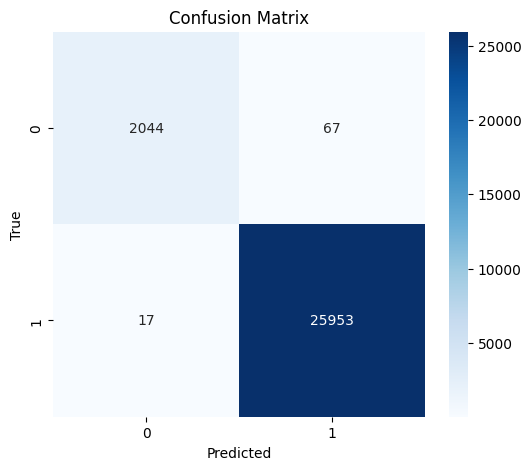

In [ ]:
y_pred = knn_from_scratch.predict(X_val)
print("f1 score: ", f1_score(y_val, y_pred, average="macro"))

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## B. Gaussian Naive Bayes

### B.1 Naive Bayes with SKLearn

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print(nb)

GaussianNB()


In [ ]:
cv_scores = cross_val_score(nb, X_train, y_train, cv=cv, scoring="f1_macro")

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.95047438 0.95323049 0.94809063]
Mean cross-validation score: 0.9505984983283904


### B.2 Naive-Bayes from Scratch

In [ ]:
class GaussianBayes:
    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y)

        self.classes = np.unique(y)
        self.parameters = {}

        for cls in self.classes:
            X_cls = X[y == cls]
            mean = X_cls.mean(axis=0)
            var = X_cls.var(axis=0) + 1e-6
            prior = X_cls.shape[0] / X.shape[0]
            self.parameters[cls] = {'mean': mean, 'var': var, 'prior': prior}

    def gaussian_prob(self, x, mean, var):
        exponent = np.exp(- ((x - mean) ** 2) / (2 * var))
        return (1 / np.sqrt(2 * np.pi * var)) * exponent

    def predict(self, X):
        X = np.array(X, dtype=float)

        y_pred = []
        for x in X:
            posteriors = []
            for cls in self.classes:
                params = self.parameters[cls]
                prior = np.log(params['prior'])
                conditional = np.sum(np.log(self.gaussian_prob(x, params['mean'], params['var'])))
                posterior = prior + conditional
                posteriors.append(posterior)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)

In [ ]:
gnb_scratch = GaussianBayes()
gnb_scratch.fit(X_train, y_train)

<ipython-input-48-c38eb5ba290f>:29: RuntimeWarning: divide by zero encountered in log
  conditional = np.sum(np.log(self.gaussian_prob(x, params['mean'], params['var'])))


f1 score:  0.9379471311284436


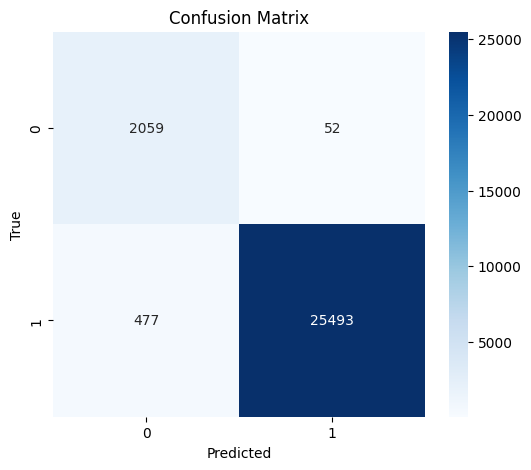

In [ ]:
y_pred = gnb_scratch.predict(X_val)
print("f1 score: ", f1_score(y_val, y_pred, average="macro"))

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## C. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

In [ ]:
# Type your code here

## D. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `label` column.

Note: Adjust step 1 and 2 to your implementation of the preprocessing step if you don't use pipeline API from `sklearn`.

In [ ]:
train = pd.read_csv("train.csv")
train.shape

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [ ]:
processed_train = custom_pipeline(train, True)
processed_train.shape

In [ ]:
X_train = processed_train.drop("label", axis=1)
y_train = processed_train["label"]

In [ ]:
test = pd.read_csv("test.csv")
test.shape

In [ ]:
processed_test = custom_pipeline(test, False)
processed_test.shape

In [ ]:
custom_knn = KNN(k=4)
custom_knn.fit(X_train, y_train)

In [ ]:
submit_pred = custom_knn.predict(processed_test)

In [ ]:
submission_df = pd.DataFrame({
    'id': test['id'],
    'label': submit_pred
})
submission_df = submission_df.set_index('id')

# 6. Error Analysis

The K-Nearest Neighbors (KNN) algorithm cannot predict with 100% accuracy whether a website is a phishing site because its performance relies heavily on the quality and representativeness of the training data. KNN classifies a website based on the characteristics of its nearest neighbors in the feature space, but phishing websites are often designed to mimic legitimate sites closely, leading to overlapping feature distributions. Additionally, variations in feature extraction, such as URL patterns or page content, can cause ambiguities. Factors like the selection of the value for kk, the distance metric used, and the curse of dimensionality in high-dimensional data can further degrade its accuracy. Finally, the dynamic and ever-evolving nature of phishing tactics can render the training data outdated, reducing the model's ability to generalize effectively to unseen examples.

Despite that, there are still room for improvements for our model. These are some of them that we have found:
* Innacurate way to impute other columns when `URL` is `NaN`
* Suboptimal imputing by using `SimpleImputer`
* Suboptimal scaling by scaling all the columns using `StandardScaler`
* Suboptimal handling of data imbalance

if those problems that we mentioned are fixed, we believe the accuracy of our model would also increase.